In [1]:
# Import helps
from src.helpers import *
from src.plots import *

# Import base
import pandas as pd
import numpy as np

# Preprocessing
from sklearn.model_selection import train_test_split

# Feature selection
from boruta import BorutaPy
from sklearn.ensemble import RandomForestClassifier
from umap import UMAP
from sklearn.pipeline import Pipeline

# tensorflow
import tensorflow as tf

import sys

pd.options.display.max_rows = 999

# Set seeds for reproducibility
set_seeds()

2024-01-03 21:07:31.362805: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-03 21:07:31.391028: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-03 21:07:31.391050: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-03 21:07:31.391756: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-03 21:07:31.396518: I tensorflow/core/platform/cpu_feature_guar

In [2]:
# class weight function
def cwts(y):
    c0, c1 = np.bincount(y)
    w0=(1/c0)*(len(y))/2 
    w1=(1/c1)*(len(y))/2 
    return {0: w0, 1: w1}

In [3]:
weights = {0: 0.5942162615255658, 1: 3.15346975088968}

In [4]:
tf.keras.backend.clear_session()

In [5]:
# Reload the saved scaled data
X_train = pd.read_csv('data/train/scaled_X_train.csv', parse_dates=True, index_col='unix')
y_train = pd.read_csv('data/train/y_train.csv', parse_dates=True, index_col='unix')
X_test = pd.read_csv('data/test/scaled_X_test.csv', parse_dates=True, index_col='unix')
y_test = pd.read_csv('data/test/y_test.csv', parse_dates=True, index_col='unix')
X_val = pd.read_csv('data/val/scaled_X_val.csv', parse_dates=True, index_col='unix')
y_val = pd.read_csv('data/val/y_val.csv', parse_dates=True, index_col='unix')

In [6]:
y = pd.concat([y_train, y_val, y_test])
y.values.flatten()
weights = cwts(y.values.flatten())

In [7]:
rf = RandomForestClassifier(n_jobs=-1, class_weight=weights)
vif = VIFTransform()
boruta = BorutaPy(rf, n_estimators='auto', verbose=2)
umap = UMAP(n_neighbors=5)
corr = RemoveCorPairwiseTransform()
pipe_1 = Pipeline([('pairwisecor', corr)], verbose=True)

In [8]:
f = open('log.txt', 'w')
sys.stdout = f
X_train = pipe_1.fit_transform(X_train, y_train.values.ravel())
X_val = pipe_1.transform(X_val)
X_test = pipe_1.transform(X_test)

In [9]:
# Reshape the data into the correct format
seqlen = 1
featurelen = X_train.shape[-1]
train_tensors = tf.keras.utils.timeseries_dataset_from_array(X_train, y_train, seqlen)
val_tensors = tf.keras.utils.timeseries_dataset_from_array(X_val, y_val, seqlen)
test_tensors = tf.keras.utils.timeseries_dataset_from_array(X_test, y_test, seqlen)

2024-01-03 21:07:42.662904: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-01-03 21:07:42.687261: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-01-03 21:07:42.687570: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [10]:
# Baseline model
inputs = tf.keras.Input(shape=(seqlen, featurelen))
x = tf.keras.layers.LSTM(36)(inputs)
outputs = tf.keras.layers.Dense(units=1, activation='sigmoid')(x)
model = tf.keras.Model(inputs, outputs)

2024-01-03 21:07:42.998485: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


In [11]:
string = model.summary(print_fn=print)

In [12]:
print(string)

In [13]:
callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=5)]

model.compile(optimizer='rmsprop', loss='binary_crossentropy',
              metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

history = model.fit(x=train_tensors, epochs=100, validation_data=val_tensors,
                    class_weight=weights, callbacks=callbacks)

2024-01-03 21:07:44.226781: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2024-01-03 21:07:44.485514: I external/local_xla/xla/service/service.cc:168] XLA service 0x7b9a509c3f90 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-01-03 21:07:44.485535: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3070 Laptop GPU, Compute Capability 8.6
2024-01-03 21:07:44.488756: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1704287264.519841   69271 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


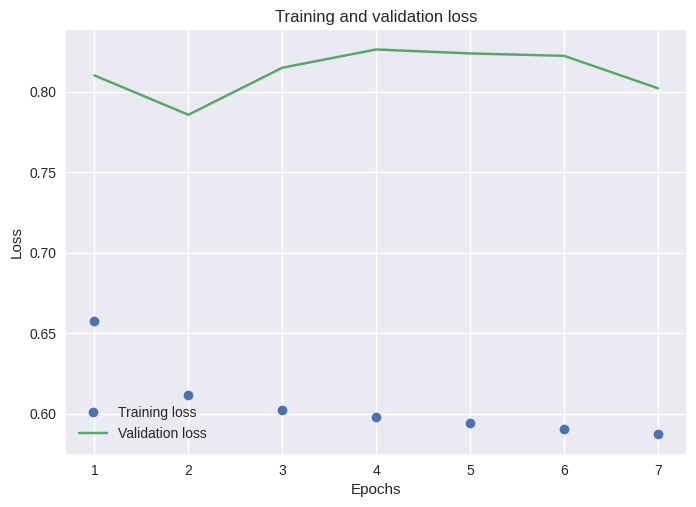

In [14]:
import matplotlib.pyplot as plt
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
plot_metrics(loss_values, val_loss_values, 'loss')

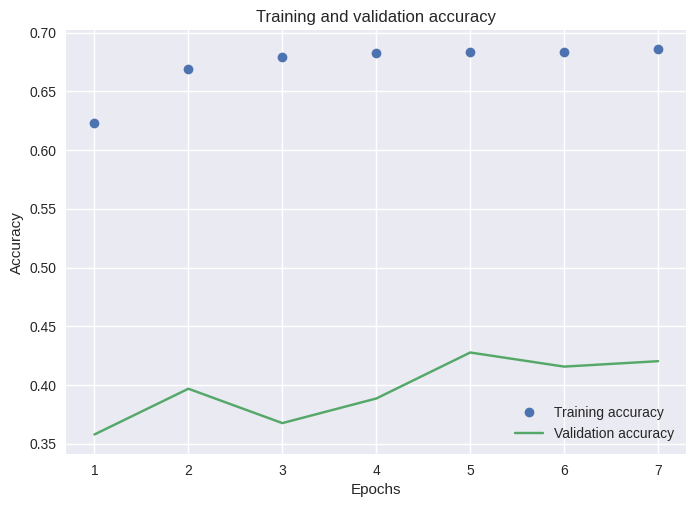

In [15]:
accuracy_values = history_dict['accuracy']
val_accuracy_values = history_dict['val_accuracy']
plot_metrics(accuracy_values, val_accuracy_values, 'accuracy')

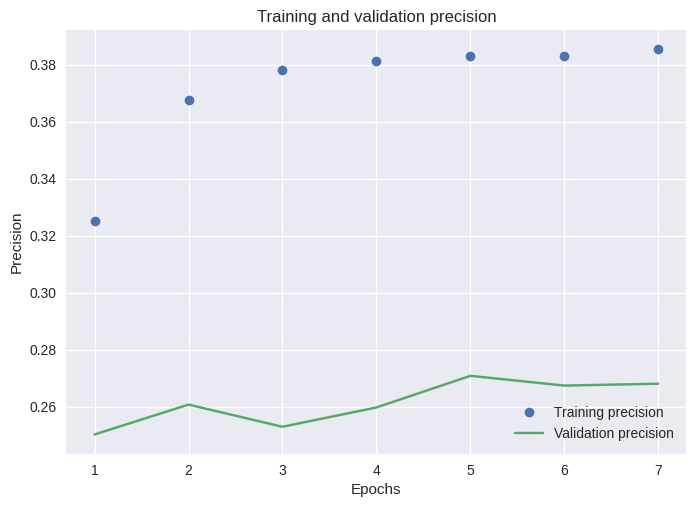

In [16]:
precision_values = history_dict['precision']
val_precision_values = history_dict['val_precision']
plot_metrics(precision_values, val_precision_values, 'precision')

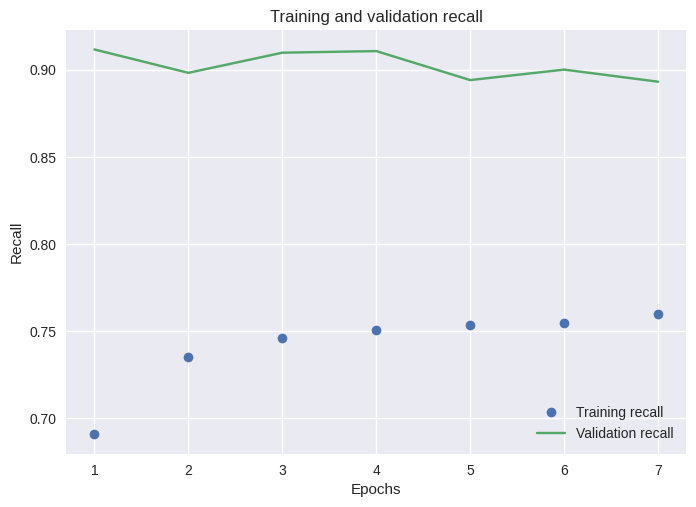

In [17]:
recall_values = history_dict['recall']
val_recall_values = history_dict['val_recall']
plot_metrics(recall_values, val_recall_values, 'recall')

In [18]:
y_pred = np.where(model.predict(test_tensors) > 0.5, 1, 0)

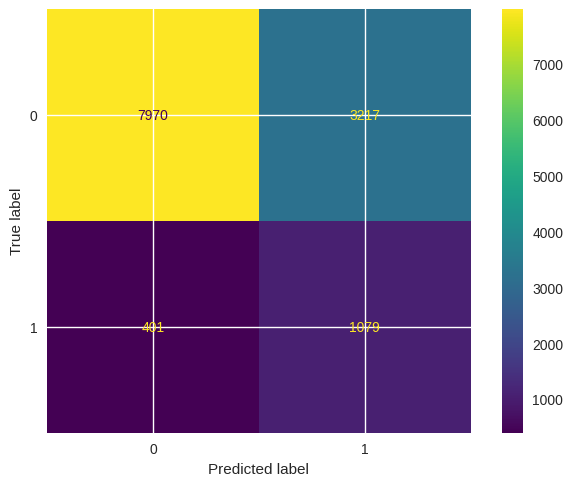

In [19]:
# Metrics
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay, classification_report

cm = confusion_matrix(y_test.values, y_pred.flatten())
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

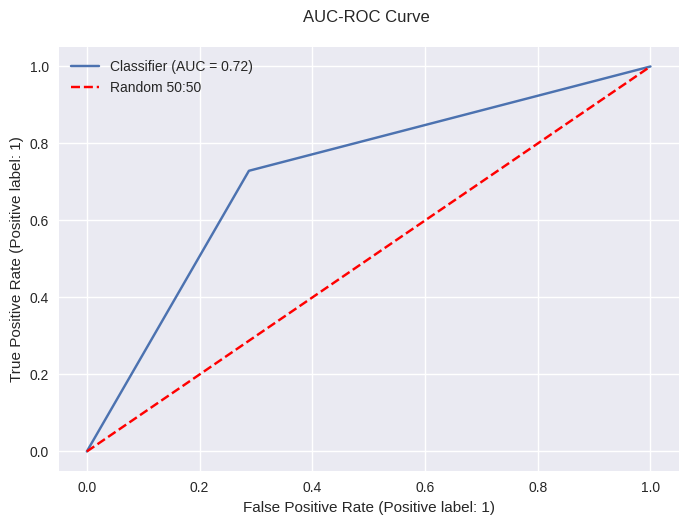

In [20]:
RocCurveDisplay.from_predictions(y_test, y_pred)
plt.title("AUC-ROC Curve \n")
plt.plot([0, 1], [0, 1], linestyle="--", label='Random 50:50', color='r')
plt.legend()
plt.show()

In [21]:
print(classification_report(y_test, y_pred))